In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import bloscpack as bp
import time
from tqdm import tqdm
from utils import*

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
points_c=get_file_ply("./data/dargon.obj")

In [55]:
print(points_c.shape)

torch.Size([100250, 6])


In [56]:
dico=dict()
bord=get_borders(points_c)

create_quadtree(dico,0,11,points_c,bord,"")

In [57]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

def get_dico_final(dico,D):
    new_dico=dict()

    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):

            for i in range(1,9):
                tmp_node=node[:-1]+str(i)
                new_dico[tmp_node]=dico[tmp_node]
    return new_dico
        

def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,6))
    o_s=torch.ones((nb_s,8,5)) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,border_father,l_points=dico[node]

            for p in l_points:
                s_p[cpt_p]=p.clone()

                gx,dx,gy,dy,gz,dz=border_father

                tmp_o_vec=torch.empty((8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    w=(s_p[cpt_p,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[7,0]=u*(1-v)*(1-w)
                        
                
                
                
                o_s[cpt_p]=tmp_o_vec.clone()
                cpt_p+=1
    return s_p,o_s


def get_os_opti(q,dico,D,distance_box):
    cpt_p=0
    s_p=torch.empty(0)
    o_s=torch.empty(0) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,border_father,l_points=dico[node]
            
            if torch.sqrt(torch.sum((o_c-q)**2))>(distance_box*1.5+o_w*8):
                continue

            for p in l_points:
                #s_p[cpt_p]=p.clone()
                s_p=torch.cat((s_p,p.clone().unsqueeze(0)),dim=0)
                

                gx,dx,gy,dy,gz,dz=border_father

                tmp_o_vec=torch.empty((1,8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[0,idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[0,idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[-1,0]-gx)/(dx-gx)
                    v=(s_p[-1,1]-gy)/(dy-gy)
                    w=(s_p[-1,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[0,1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[0,2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[0,3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[0,4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[0,5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[0,6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[0,7,0]=u*(1-v)*(1-w)
                        
                
                
                
                #o_s[cpt_p]=tmp_o_vec.clone()
                o_s=torch.cat((o_s,tmp_o_vec.clone()),dim=0)
                cpt_p+=1
    return s_p,o_s

def get_V_q(q,l_o,l_s):
    q_vec=torch.empty((l_o.shape[0],8,3))
    q_vec[:,:,0]=q[0]
    q_vec[:,:,1]=q[1]
    q_vec[:,:,2]=q[2]
    
    q_vec[:,:,0]-=l_o[:,:,2]
    q_vec[:,:,0]/=l_o[:,:,1]
    q_vec[:,:,1]-=l_o[:,:,3]
    q_vec[:,:,1]/=l_o[:,:,1]
    q_vec[:,:,2]-=l_o[:,:,4]
    q_vec[:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=2)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    
    res=torch.empty((l_o.shape[0],8,3))
    res[:,0]=l_s[:,3:]
    res[:,1]=l_s[:,3:]
    res[:,2]=l_s[:,3:]
    res[:,3]=l_s[:,3:]
    res[:,4]=l_s[:,3:]
    res[:,5]=l_s[:,3:]
    res[:,6]=l_s[:,3:]
    res[:,7]=l_s[:,3:]

    res[:,0,0]*=test[:,0]
    res[:,0,1]*=test[:,0]
    res[:,0,2]*=test[:,0]
    res[:,1,0]*=test[:,1]
    res[:,1,1]*=test[:,1]
    res[:,1,2]*=test[:,1]
    res[:,2,0]*=test[:,2]
    res[:,2,1]*=test[:,2]
    res[:,2,2]*=test[:,2]
    res[:,3,0]*=test[:,3]
    res[:,3,1]*=test[:,3]
    res[:,3,2]*=test[:,3]
    res[:,4,0]*=test[:,4]
    res[:,4,1]*=test[:,4]
    res[:,4,2]*=test[:,4]
    res[:,5,0]*=test[:,5]
    res[:,5,1]*=test[:,5]
    res[:,5,2]*=test[:,5]
    res[:,6,0]*=test[:,6]
    res[:,6,1]*=test[:,6]
    res[:,6,2]*=test[:,6]
    res[:,7,0]*=test[:,7]
    res[:,7,1]*=test[:,7]
    res[:,7,2]*=test[:,7]
    
    res=torch.sum(res,dim=(0,1))
    
    return res

def get_V_tmp(coords_grid,l_o,l_s):
    #q [ r_x , r_y , r_z,  3 ]
    #     0    1     2    3

    q=coords_grid.clone().unsqueeze(3).unsqueeze(4).repeat(1,1,1,l_o.shape[0],8,1).to(device) 
    #q [ r_x , r_y , r_z, l_o , 8 , 3 ]
    #     0     1     2    3    4   5

    q[:,:,:,:,:,0]-=l_o[:,:,2]
    q[:,:,:,:,:,0]/=l_o[:,:,1]
    q[:,:,:,:,:,1]-=l_o[:,:,3]
    q[:,:,:,:,:,1]/=l_o[:,:,1]
    q[:,:,:,:,:,2]-=l_o[:,:,4]
    q[:,:,:,:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q)**2,dim=5)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    

    res=l_s[:,3:].clone().unsqueeze(1).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device) 
    res=res.repeat(coords_grid.shape[0],coords_grid.shape[1],coords_grid.shape[2],1,8,1).to(device) 
    



    res[:,:,:,:,0,0]*=test[:,:,:,:,0]
    res[:,:,:,:,0,1]*=test[:,:,:,:,0]
    res[:,:,:,:,0,2]*=test[:,:,:,:,0]
    res[:,:,:,:,1,0]*=test[:,:,:,:,1]
    res[:,:,:,:,1,1]*=test[:,:,:,:,1]
    res[:,:,:,:,1,2]*=test[:,:,:,:,1]
    res[:,:,:,:,2,0]*=test[:,:,:,:,2]
    res[:,:,:,:,2,1]*=test[:,:,:,:,2]
    res[:,:,:,:,2,2]*=test[:,:,:,:,2]
    res[:,:,:,:,3,0]*=test[:,:,:,:,3]
    res[:,:,:,:,3,1]*=test[:,:,:,:,3]
    res[:,:,:,:,3,2]*=test[:,:,:,:,3]
    res[:,:,:,:,4,0]*=test[:,:,:,:,4]
    res[:,:,:,:,4,1]*=test[:,:,:,:,4]
    res[:,:,:,:,4,2]*=test[:,:,:,:,4]
    res[:,:,:,:,5,0]*=test[:,:,:,:,5]
    res[:,:,:,:,5,1]*=test[:,:,:,:,5]
    res[:,:,:,:,5,2]*=test[:,:,:,:,5]
    res[:,:,:,:,6,0]*=test[:,:,:,:,6]
    res[:,:,:,:,6,1]*=test[:,:,:,:,6]
    res[:,:,:,:,6,2]*=test[:,:,:,:,6]
    res[:,:,:,:,7,0]*=test[:,:,:,:,7]
    res[:,:,:,:,7,1]*=test[:,:,:,:,7]
    res[:,:,:,:,7,2]*=test[:,:,:,:,7]

    
    
    res=torch.sum(res,dim=(3,4)).to(device) 
   
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )



In [ ]:
#octree depth

#grid resolution


#
#l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_vec(points_c,dico,D,name="V.blp"):
    
    l_s,l_o=get_os(points_c.shape[0],dico,D)

    batch_size=256
    batch_size_grid=32

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()
    resolution=128
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)

    grid_coords=torch.zeros((resolution,resolution,resolution,3))
    grid_res=torch.zeros((resolution,resolution,resolution,3))

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z

    

    
    for batch_samples in tqdm(range(0,l_o.shape[0],batch_size)):

        tmp_l_s=l_s[batch_samples:batch_samples+batch_size].to(device) 
        tmp_l_o=l_o[batch_samples:batch_samples+batch_size].to(device) 

        for u in (range(0,grid_coords.shape[0],batch_size_grid)):
            for v in (range(0,grid_coords.shape[1],batch_size_grid)):
                for w in range(0,grid_coords.shape[2],batch_size_grid):
        
                    #start_time = time.time()
                    tmp_grid=grid_coords[u:u+batch_size_grid,v:v+batch_size_grid,w:w+batch_size_grid].to(device)
                    grid_res[u:u+batch_size_grid,v:v+batch_size_grid,w:w+batch_size_grid]+=get_V_tmp(tmp_grid,tmp_l_o,tmp_l_s).detach().cpu()
                    #end_time = time.time()
                    #print("---Computation time %s seconds ---" % (np.around(end_time - start_time,5)),"   ",l_o.shape)

    
    bp.pack_ndarray_to_file(grid_res.numpy(), name)


def get_V_opti(points_c,dico,D,name="V.blp"):

    new_dico=get_dico_final(dico,D)

    print(len(dico),"    len new dico:",len(new_dico))
    
    l_s,l_o=get_os(points_c.shape[0],dico,D)

    batch_size=4

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()
    
    resolution=64
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)

    grid_coords=torch.zeros((resolution,resolution,resolution,3))
    grid_res=torch.zeros((resolution,resolution,resolution,3))

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z

    for u in tqdm(range(0,grid_coords.shape[0],batch_size)):
        for v in (range(0,grid_coords.shape[1],batch_size)):
            for w in range(0,grid_coords.shape[2],batch_size):

                central_p=torch.zeros(3)
                max_p=torch.zeros(3)
                central_p[0] = torch.mean(grid_coords[u:u+batch_size,v:v+batch_size,w:w+batch_size,0])
                central_p[1] = torch.mean(grid_coords[u:u+batch_size,v:v+batch_size,w:w+batch_size,1])
                central_p[2] = torch.mean(grid_coords[u:u+batch_size,v:v+batch_size,w:w+batch_size,2])

                max_p[0] = torch.max(grid_coords[u:u+batch_size,v:v+batch_size,w:w+batch_size,0])
                max_p[1] = torch.max(grid_coords[u:u+batch_size,v:v+batch_size,w:w+batch_size,1])
                max_p[2] = torch.max(grid_coords[u:u+batch_size,v:v+batch_size,w:w+batch_size,2])

                
                distance_box=torch.sqrt(torch.sum((central_p-max_p)**2))

                start_time = time.time()    
                l_s,l_o=get_os_opti(central_p,new_dico,D,distance_box)
                end_time = time.time()

                l_s=l_s.to(device) 
                l_o=l_o.to(device) 

                #print("--- %s seconds ---" % (np.around(end_time - start_time,5)),"   ",l_o.shape)
                
                if len(l_o.shape)==1:
                    print("ok")
                    continue
                
                
                #start_time = time.time()
                grid_res[u:u+batch_size,v:v+batch_size,w:w+batch_size]+=get_V_tmp(grid_coords[u:u+batch_size,v:v+batch_size,w:w+batch_size],l_o,l_s).detach().cpu()
                #end_time = time.time()
                #print("---Computation time %s seconds ---" % (np.around(end_time - start_time,5)),"   ",l_o.shape)

        
        

    bp.pack_ndarray_to_file(grid_res.numpy(), name)

    
    

    
    
start_time = time.time()    
get_V_vec(points_c,dico,D=6,name="V.blp")   
end_time = time.time()

print("--- %s seconds ---" % (np.around(end_time - start_time,5)))

  6%|██████▋                                                                                                       | 24/392 [02:40<40:54,  6.67s/it]

In [47]:
def show_V(name="V.blp"):

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()
    

    X, Y, Z = np.mgrid[min_x:max_x:32j, min_y:max_y:32j, min_z:max_z:32j]
    
    values = bp.unpack_ndarray_from_file(name)
    rendu=np.sqrt(values[:,:,:,0]**2+values[:,:,:,1]**2+values[:,:,:,2]**2)
    layout = go.Layout(
        autosize=False,
        width=1000,
        height=1000,
        xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
        yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
        margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
        )
        
    fig = go.Figure(data=go.Volume(
    x=X[:,:,:].flatten(),
    y=Y[:,:,:].flatten(),
    z=Z[:,:,:].flatten(),
    value=rendu.flatten(),
    isomin=4.,
    isomax=np.max(rendu),
    colorscale='greys',
    opacity=0.9, # needs to be small to see through all surfaces
    surface_count=10, # needs to be a large number for good volume rendering
    ),layout=layout)

    
    fig.show()

In [48]:
#show_V(name="V.blp")

In [49]:
values = bp.unpack_ndarray_from_file("V.blp")
values=torch.from_numpy(values)

In [50]:
def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1], V.shape[2]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :,:] += (V[2:, :,:, 0] - V[:-2, :,:, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1,:] += (V[:, 2:,:, 1] - V[:, :-2,:, 1]) / 2
    div_V[:, :,1:-1] += (V[:,: ,2:, 2] - V[:, :, :-2, 2]) / 2
    
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :,:] += (V[1, :,:, 0] - V[0, :,:, 0])
    div_V[-1, :,:] += (V[-1, :,:, 0] - V[-2, :,:, 0])
    div_V[:, 0,:] += (V[:, 1,:, 1] - V[:, 0,:, 1])
    div_V[:, -1,:] += (V[:, -1,:, 1] - V[:, -2,:, 1])
    div_V[:,:, 0] += (V[:, :,1, 1] - V[:,:, 0, 1])
    div_V[:,:, -1] += (V[:, :,-1, 1] - V[:,:, -2, 1])

    return div_V

    

In [51]:
grad=compute_divergence(values)
print(grad.shape)

torch.Size([128, 128, 128])


In [52]:
borders=get_borders(points_c)
        
min_x=borders[0].item()
max_x=borders[1].item()
min_y=borders[2].item()
max_y=borders[3].item()
min_z=borders[4].item()
max_z=borders[5].item()

min_coord=min(min_x,min_y)
min_coord=min(min_coord,min_z)
min_coord=min_coord

max_coord=max(max_x,max_y)
max_coord=max(max_coord,max_z)
max_coord=max_coord

X_plot, Y_plot = np.mgrid[0:256:256j, 0:256:256j]





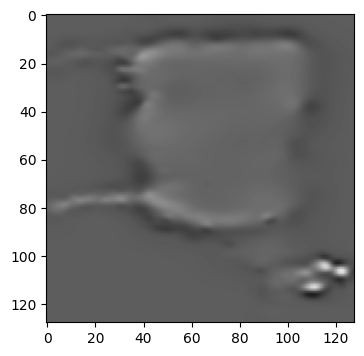

In [53]:
fig = plt.figure(figsize=plt.figaspect(0.25))
slice=40
ax = fig.add_subplot(1, 1, 1)
plt.imshow(grad[:,:,slice],cmap="gray",vmin=torch.min(grad),vmax=torch.max(grad))


#plt.quiver(X_plot,Y_plot,values[:,:,slice,0],values[:,:,slice,1],alpha = 0.5,scale = 0.1)


In [ ]:



N=grad.shape[0]

x=np.linspace(0,N-1,N)
y=np.linspace(0,N-1,N)
z=np.linspace(0,N-1,N)
gridx, gridy, gridz=np.meshgrid(x,y,z)
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(gridx, gridy, gridz, c=grad,cmap="Greys",alpha=0.01)
plt.show()

In [ ]:


def get_list_gaussians(borders,D):
    res_centers=torch.empty(8**D,4)
    borders=get_borders(points_c)

    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()
    min_z=borders[4].item()
    max_z=borders[5].item()

    Width=(max_x-min_x)/(2**D)
    cpt_idx=0

    for i in range(2**D):
        for j in range(2**D):
            for w in range(2**D):
            
                xa=min_x+(i*Width)+Width/2.0
                ya=min_y+(j*Width)+Width/2.0
                za=min_z+(w*Width)+Width/2.0
        
                res_centers[cpt_idx,0]=xa
                res_centers[cpt_idx,1]=ya
                res_centers[cpt_idx,2]=za
                res_centers[cpt_idx,3]=Width
                
                cpt_idx+=1
    return res_centers

In [ ]:
bord=get_borders(points_c)
L_gaussians=get_list_gaussians(bord,5)
print(L_gaussians.shape)

In [ ]:
def get_inner_product_gradVB(V,L_gaussians,borders):
    res=torch.empty(L_gaussians.shape[0])

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()

    resolution=128
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)
    
    
    grid_coords=torch.zeros((resolution,resolution,resolution,3))
    

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z

    
    


    for idx_gaussian in range(L_gaussians.shape[0]):
        tmp_res=grid_coords.clone()
        tmp_sum_g=(tmp_res[:,:,:,0]-L_gaussians[idx_gaussian,0])**2
        tmp_sum_g+=(tmp_res[:,:,:,1]-L_gaussians[idx_gaussian,1])**2
        tmp_sum_g+=(tmp_res[:,:,:,2]-L_gaussians[idx_gaussian,2])**2
        
        tmp_sum_g=torch.exp(-(tmp_sum_g/(2*L_gaussians[idx_gaussian,3]**2)))
        
        tmp_sum_g=tmp_sum_g*V*(2*L_gaussians[idx_gaussian,3]**2)
        tmp_sum_g=torch.sum(tmp_sum_g)
        res[idx_gaussian]=tmp_sum_g
        
    
    
        
    return res

In [ ]:
V_o=get_inner_product_gradVB(grad,L_gaussians,bord)

In [ ]:
print(V_o.shape)

#plt.imshow(V_o.reshape((np.uint(np.sqrt(V_o.shape[0])),np.uint(np.sqrt(V_o.shape[0])))))
#plt.colorbar()

In [ ]:
def get_inner_product_gradB_B_vec(size_grid, L_gaussians, borders):
    res = torch.zeros((L_gaussians.shape[0], L_gaussians.shape[0]))

    batch_size=min(L_gaussians.shape[0],256)

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()

    width_x = max_x - min_x
    width_y = max_y - min_y
    width_z = max_z - min_z

    xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=size_grid)
    ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=size_grid)
    zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=size_grid)
    
    x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

    grid = torch.empty(size_grid, size_grid, size_grid, 3)
    grid[:, :, :, 0] = x
    grid[:, :, :, 1] = y
    grid[:, :, :, 2] = z
    
    cpt_economies=0

    for idx_gaussian_1 in range(L_gaussians.shape[0]):
        if (idx_gaussian_1%1000==0):
            print(idx_gaussian_1,"\t\t",cpt_economies)
        for idx_gaussian_2 in range(idx_gaussian_1, L_gaussians.shape[0], batch_size):
            batch_end = min(idx_gaussian_2 + batch_size, L_gaussians.shape[0])
            taille_tmp = batch_end - idx_gaussian_2

            tmp_g1 = grid.clone().unsqueeze(0).repeat((taille_tmp, 1, 1, 1, 1))
            
            tmp_g1 = torch.exp(-((tmp_g1[:,:,:,:,0] - L_gaussians[idx_gaussian_1, 0])**2 + (tmp_g1[:,:,:,:,1] - L_gaussians[idx_gaussian_1, 1])**2+(tmp_g1[:,:,:,:,2] - L_gaussians[idx_gaussian_1, 2])**2) / (2 * L_gaussians[idx_gaussian_1, 3]**2))

            tmp_g2 = grid.clone().unsqueeze(0).repeat((taille_tmp, 1, 1, 1, 1))
            L_gaussian_0_vec = L_gaussians[idx_gaussian_2:batch_end, 0].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2]))
            L_gaussian_1_vec = L_gaussians[idx_gaussian_2:batch_end, 1].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2]))
            L_gaussian_2_vec = L_gaussians[idx_gaussian_2:batch_end, 2].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2]))
            L_gaussian_3_vec = L_gaussians[idx_gaussian_2:batch_end, 3].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2]))

            fac_x = ((tmp_g2[:,:,:,:,0] - L_gaussian_0_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)
            fac_y = ((tmp_g2[:,:,:,:,1] - L_gaussian_1_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)
            fac_z = ((tmp_g2[:,:,:,:,2] - L_gaussian_2_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)

            map_g2 = torch.exp(-((tmp_g2[:,:,:,:,0] - L_gaussian_0_vec)**2 + (tmp_g2[:,:,:,:,1] - L_gaussian_1_vec)**2 + (tmp_g2[:,:,:,:,2] - L_gaussian_2_vec)**2) / (2 * L_gaussian_3_vec**2))
            tmp_g2[:,:,:,:,0] = fac_x * map_g2.clone()
            tmp_g2[:,:,:,:,1] = fac_y * map_g2.clone()
            tmp_g2[:,:,:,:,2] = fac_z * map_g2.clone()

            tmp_res = torch.sum(tmp_g1 * tmp_g2[:,:,:,:,0] * (L_gaussian_3_vec**2), dim=[1, 2, 3]) 
            tmp_res += torch.sum(tmp_g1 * tmp_g2[:,:,:,:,1] * (L_gaussian_3_vec**2), dim=[1, 2, 3])
            tmp_res += torch.sum(tmp_g1 * tmp_g2[:,:,:,:,2] * (L_gaussian_3_vec**2), dim=[1, 2, 3])
            if torch.sum(torch.abs(tmp_res))<1e-8:
                cpt_economies+= max(0,L_gaussians.shape[0]-(idx_gaussian_2+batch_size))
                break
            res[idx_gaussian_1, idx_gaussian_2:batch_end] = tmp_res

    res += torch.flip(res, [0, 1])

    for idx_gaussian_1 in range(L_gaussians.shape[0]):
        res[idx_gaussian_1, idx_gaussian_1] *= 0.5

    cpt_economies=cpt_economies+(((L_gaussians.shape[0])**2)/2.0)-L_gaussians.shape[0]

    print(cpt_economies,"     ",(cpt_economies/(L_gaussians.shape[0]**2))*100,"%")

    return res

In [ ]:
#L_oo=get_inner_product_gradB_B(grad.shape[0],L_gaussians,bord)
L_oo=get_inner_product_gradB_B_vec(32,L_gaussians,bord)

In [ ]:
#print(torch.allclose(L_oo,L_oo_vec))
print(L_oo.shape)
plt.imshow(L_oo,interpolation="none")
plt.colorbar()

In [ ]:
import torch.optim as optim

def grad_loss(L,img,V):
    
    
    return torch.sqrt(torch.mean((torch.matmul(L,img)-V)**2))


def fit(L,V):
    optimizer=optim.LBFGS([torch.zeros(0)],lr=1e-2, max_iter=100)
    eps_b=V.clone()#torch.randn(V.shape)
    eps_b.requires_grad = True
    optimizer.param_groups[0]['params'][0] = eps_b

    def closure():
        optimizer.zero_grad()
        loss=grad_loss(L,eps_b,V)
        loss.backward(retain_graph=True)
        return loss
    loss=optimizer.step(closure)
    print(loss)
    
    return eps_b

eps=fit(L_oo,V_o)

eps=eps.detach()
print(eps.shape)

In [ ]:
#grid resolution
n_p=128

min_x=torch.min(points_c[:,0]).item()
max_x=torch.max(points_c[:,0]).item()
min_y=torch.min(points_c[:,1]).item()
max_y=torch.max(points_c[:,1]).item()
min_z=torch.min(points_c[:,2]).item()
max_z=torch.max(points_c[:,2]).item()

width_x=max_x-min_x
width_y=max_y-min_y
width_z=max_y-min_z

image_res=torch.zeros((n_p,n_p,n_p))

xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=n_p)
ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=n_p)
zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=n_p)

x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

grid = torch.empty(n_p, n_p, n_p, 3)
grid[:, :, :, 0] = x
grid[:, :, :, 1] = y
grid[:, :, :, 2] = z


def get_X(x,l_g,q):
    res=torch.sum(torch.exp(-((q[0] - l_g[:,0])**2 + (q[1] - l_g[:,1])**2 + (q[2] - l_g[:,2])**2 ) / (l_g[0,3] * 2)**2)*x)

    return res
        





for i in range(xs.shape[0]):
    for j in range(xs.shape[0]):
        for w in range(xs.shape[0]):
            image_res[i,j,w]=get_X(eps,L_gaussians,grid[i,j,w])

In [ ]:



N=grad.shape[0]

x=np.linspace(0,N-1,N)
y=np.linspace(0,N-1,N)
z=np.linspace(0,N-1,N)
gridx, gridy, gridz=np.meshgrid(x,y,z)
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(gridx, gridy, gridz, c=image_res,cmap="Greys",alpha=0.025)
plt.show()